In [1]:
from pathlib import Path

import polars as pl
from atollgen_cli.runner import DataHolder
from entrez_fetcher.genome_store import GenomeStore
from matplotlib import pyplot as plt
from scibelt.aggregates import Dataset, aggregate_format, format_data
from scibelt.viz import (
    FigureSaver,
    get_legend_hl,
    propbarplot,
    alias_or_name,
    latex_size,
)
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
import matplotlib.patches as mpatches
import numpy as np

In [2]:
data_holder = DataHolder(Path("../data/interim/"), ensure_data=False)
adb_path = data_holder.db_dir / "adb"
adb_sources_dir = data_holder.db_dir / "sources"
genome_store_dir = data_holder.db_dir / "genomes"
genome_store = GenomeStore(genome_store_dir)

ds = Dataset.from_folder(
    "../data/post-process/base_overlaps/", genome_store=genome_store
)

fs = FigureSaver("../figures/supp/fig08/")

In [3]:
def combi_n(df, ntop=10):

    total = pl.concat_list(pl.col(pl.NUMERIC_DTYPES)).list.sum().alias("total")
    topn = (
        df.select("combi", total)
        .sort("total", descending=True)[:ntop]["combi"]
        .to_list()
    )

    combi_top = df.filter(pl.col("combi").is_in(topn))
    combi_top = aggregate_format(combi_top, columns="label", index="combi")
    combi_top = combi_top.sort(total, descending=True)
    return combi_top

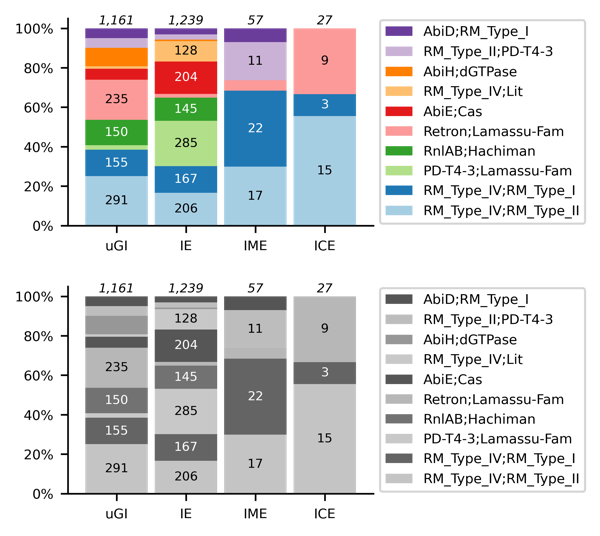

In [4]:
df = ds.defensefinder_combination_by_label.select(
    pl.all().exclude("psiICE")
)
combi_len = pl.col("combi").str.split(";").list.lengths()
subdf = df.filter(combi_len == 2)
df = combi_n(subdf, 10)
df = df.select(
    "combi", *[col for col in df.columns if col != "combi" and df[col].sum() > 0]
)

with latex_size(double=False, width_prop=0.8, height=1.8), sns.color_palette("Paired"):
    fig, ax = plt.subplots()
    propbarplot(
        df.to_pandas().set_index("combi").T,
        ax=ax,
        legend=False,
        kind="bar",
    )
    ax.legend(*get_legend_hl(ax), ncol=1, loc="center left", bbox_to_anchor=(1.0, 0.5))
    ax.grid(False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_xlabel("")
    ax.set_yticks(np.arange(0, 1.01, 0.2))
fs.savefig(fig, "panel_A")

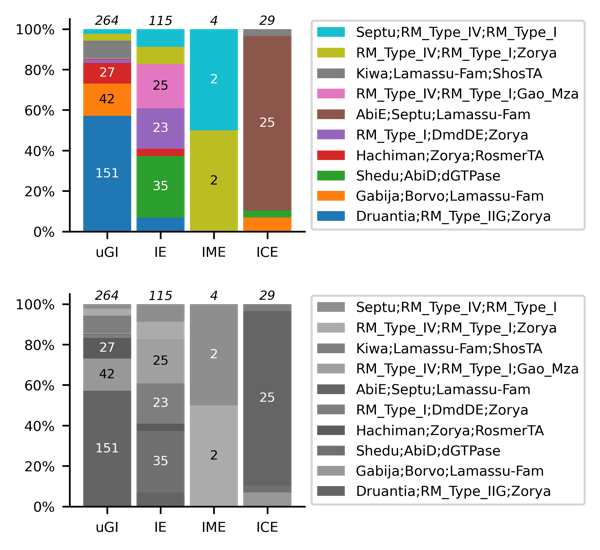

In [5]:
df = ds.defensefinder_combination_by_label.select(
    pl.all().exclude("psiICE")
)
combi_len = pl.col("combi").str.split(";").list.lengths()
subdf = df.filter(combi_len == 3)
df = combi_n(subdf, 10)
df = df.select(
    "combi", *[col for col in df.columns if col != "combi" and df[col].sum() > 0]
)

with latex_size(double=False, width_prop=0.6, height=1.8), sns.color_palette("tab10"):
    fig, ax = plt.subplots()
    propbarplot(
        df.to_pandas().set_index("combi").T,
        ax=ax,
        legend=False,
        kind="bar",
    )
    ax.legend(*get_legend_hl(ax), ncol=1, loc="center left", bbox_to_anchor=(1.0, 0.5))
    ax.grid(False)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_xlabel("")
    ax.set_yticks(np.arange(0, 1.01, 0.2))
fs.savefig(fig, "panel_B")

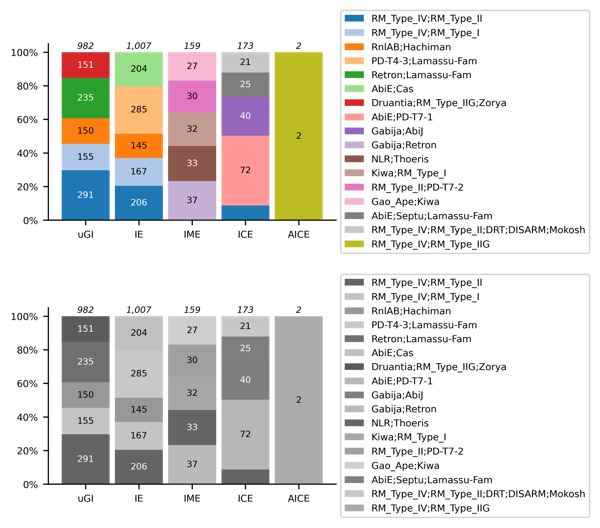

In [6]:
from functools import reduce


df = ds.defensefinder_combination_by_label.select(pl.all().exclude("psiICE")).filter(
    pl.col("combi").is_not_null()
)
df = df.filter(pl.col("combi").str.contains(";"))
df = reduce(
    lambda df, other: df.join(other, on="combi", how="outer"),
    [
        df.select("combi", col).sort(col, descending=True)[:5]
        for col in df.columns
        if col != "combi"
    ],
)
df = df.with_columns(pl.col(pl.NUMERIC_DTYPES).fill_null(0))
df = df.filter(pl.concat_list(pl.col(pl.NUMERIC_DTYPES)).list.sum() > 0)
df = aggregate_format(df, index="combi", columns="label")
df = df.select(
    "combi", *[col for col in df.columns if col != "combi" and df[col].sum() > 0]
)
df = df.sort(pl.concat_list(pl.col(pl.NUMERIC_DTYPES)).list.sum(), descending=True)
with latex_size(double=True, width_prop=0.5), sns.palettes.color_palette("tab20"):
    fig, ax = plt.subplots()
    propbarplot(
        df.to_pandas().set_index("combi").T,
        ax=ax,
        legend=False,
        kind="bar",
    )
    ax.legend(
        *ax.get_legend_handles_labels(),
        ncol=1,
        loc="center left",
        bbox_to_anchor=(1.0, 0.5),
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.grid(False)
    ax.set_xlabel("")
    ax.set_yticks(np.arange(0, 1.01, 0.2))
fs.savefig(fig, "panel_C")